![title](logo.png)

_____

# Desafio 7 - Prever a Nota de Matemática do ENEM 2016
_____

### Base de Dados

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo enem_train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. 

Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

Muitas universidades brasileiras utilizam o ENEM para selecionar seus futuros alunos e alunas. Isto é feito com uma média ponderada das notas das provas de matemática, ciências da natureza, linguagens e códigos, ciências humanas e redação. Determine os 20 melhores colocados, por ordem, para os pesos abaixo:

- matemática: 3
- ciências da natureza: 2
- linguagens e códigos: 1.5
- ciências humanas: 1
- redação: 3

O micro dados do INEP está disponível em: http://inep.gov.br/microdados


### Objetivo

Criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016. 

O objetivo do desafio é avaliar a sua capacidade de resolver problemas, então ele pode ser resolvido em qualquer linguagem de programação ou ferramenta que você tenha facilidade. Mas recomendamos o uso de linguagens com maior ferramental de matemática e estatística como Python, R, Scala ou Julia.

No arquivo enem_test.csv crie um modelo para prever nota da prova de matemática (coluna **NU_NOTA_MT**) de quem participou do ENEM 2016. 

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: **NU_INSCRICAO** e **NU_NOTA_MT**.
___________________

### Informações Adicionais
Este mesmo desafio foi proposto no processo seletivo para ingressar na aceleração. 

Caso queira ver o primeiro modelo que fiz acesse o repositório em: https://github.com/Dlyra/predicao_nota_matematica_enem_2016 

O score obtido foi de:

![title](Score_Modelo2.png)

_______
### Importando as bibliotecas

In [1119]:
import pandas as pd
import numpy as np
from IPython.display import Image
import joblib

# visualização gráfica
import seaborn as sns 
import matplotlib.pyplot as plt

# estatísticas
from pandas_profiling import ProfileReport

# modelo
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor


from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import sklearn.metrics as metrics

## Análise Exploratória
_______

In [1072]:
# importa os arquivos teste e train
test = pd.read_csv('./enem_test.csv', sep=",",encoding="utf-8")
train = pd.read_csv('./enem_train.csv',sep=",",encoding="utf-8")

# cria o dataset de respostas que será enviado ao desafio
df_resposta = pd.DataFrame()

# insere a coluna de inscrição
df_resposta['NU_INSCRICAO'] = test['NU_INSCRICAO'] 

In [1073]:
# visualiza os dados do arquivo train
train.head(2)

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A


In [1074]:
# visualiza os dados do arquivo test
test.head(2)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,100.0,580.0,E,B,C,B,B,B,F,A


In [1075]:
# verificar se os dados de teste estão nos dados de treinamento
print(set(test.columns).issubset(set(train.columns)))

True


In [1076]:
# verifica as colunas que constam nos dois arquivos.
test.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE',
       'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

In [1077]:
train.columns

Index(['Unnamed: 0', 'NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       ...
       'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049',
       'Q050'],
      dtype='object', length=167)

In [1078]:
# verifica o tamanho dos dados linhas e colunas
print('Dados Teste:', test.shape) 
print('Dados Treino:',train.shape)

Dados Teste: (4576, 47)
Dados Treino: (13730, 167)


Os dados de treino e teste possuem tamanhos diferentes, o teste possui apenas 47 colunas o que limita um pouco a escolha das features para criar o modelo. 

### Profile Report

O pandas profiling é uma ferramenta que gera um relatório com informações estatísticas e as principais características do seu dataframe.

___

In [75]:
# executando o profile
profile = ProfileReport(test, title='Relatório - Pandas Profiling', html={'style':{'full_width':True}})

In [76]:
# salvando o relatório no disco para acesso numa página externa. 
profile.to_file(output_file="Relatorio_test.html")

In [ ]:
# visualiza o relatório no notebook
profile

 Após a análise das variáveis no profile seleciona aquelas que serão as features do modelo.

## Pré-Processamento

____

### Ajustes

Como vimos, o tamanho das features dos dataset de treino e teste possuem tamanhos diferentes o que irá limitar um pouco nossa escolhas.

Para facilitar vou definir que ambos possuam a mesma quantidade de features.

In [1079]:
# faz uma cópia do dataframe importado
df_train = train.copy()
df_test = test.copy()

In [1081]:
# valida os tamanhos dos dados
print(df_test.shape)
print(df_train.shape)

(4576, 47)
(13730, 167)


In [1083]:
# verifica as colunas que constam em teste.
columns_ajust = list(test.columns)
columns_ajust

['NU_INSCRICAO',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'CO_PROVA_CN',
 'CO_PROVA_CH',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

In [1084]:
# vamos adicionar a variável target nas features existentes 
columns_ajust.append('NU_NOTA_MT')
columns_ajust

['NU_INSCRICAO',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'CO_PROVA_CN',
 'CO_PROVA_CH',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'NU_NOTA_MT']

In [1085]:
# ajustar as colunas no dataset de treino ao de teste
df_train = df_train[columns_ajust]
df_train.head(2)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,520.0,D,D,C,A,A,C,H,A,399.4
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,580.0,A,A,B,A,A,A,NaN,A,459.8


In [1086]:
# valida os tamanhos dos dados
print(df_test.shape)
print(df_train.shape) # tem 01 a mais que é a nossa target 'NU_NOTA_MT'

(4576, 47)
(13730, 48)


### Verificar os Campos Nulos

- **Q027** representa um dado do questionário socioeconômico - **"Com que idade você começou a exercer uma atividade remunerada?"**.

    Para esse campo estar em branco, entendo que o candidato preencheu o campo anterior **Q026 que é "Você exerce ou já excerceu atividade remunerada?**, porém optou em deixar em branco a pergunta seguinte que é a Q027 e não escolheu nenhuma das idades sugeridas nesse item. 

    Poderia até preencher com a média uma vez que tenho as opções B - 14 anos, C - 15 anos etc. 

    Porém, possuo duas opções nesse item que me impede, são eles: A - Menos de 14 anos e M - 25 anos ou mais.


- **TP_ENSINO - "Tipo de Instituição que concluiu ou concluirá o Ensino Médio"** - apesar de ser uma variável numérica, os números representam a descrição abaixo. 

    Esse campo em branco, significa que o candidato escolheu algumas das opções do item anterior TP_ESCOLA que é o tipo de escola do ensino médio. 

        - 1 - Ensino Regular
        - 2 - Educação especial- modalidade susbtitutiva
        - 3 - Educação de Jovens e Adultos
        

    Entretanto, em **TP_ESCOLA temos que 1 significa que o candidato não respondeu**, o número desse campo deveria ser o mesmo que os faltantes do TP_ENSINO. 

    As quantidade não correspondem, porém a diferença não é relevante e o mesmo acontece em **TP_DEPENDENCIA_ADM_ESC**. 

- **NU_NOTA_$ - Correspondem aos campos das notas das provas**: CN- Ciência da Natureza, CH- Ciência Humanas, LC- Linguagens e Códigos e MT- Matemática e Redação.

    Existe uma divergência, temos que 208 candidatos possuem notas em CN e CH o que nos diz que compareceram no primeiro dia de prova e faltaram no segundo.

    Faltaram 3389 candidatos nos dois dias de prova. 

In [1089]:
# verificar a quantidade de candidatos que optou não responder
tp_escola = df_train['TP_ESCOLA'][df_train['TP_ESCOLA'] == 1]  
tp_escola.count()

9447

In [1088]:
df_train.isnull().sum()

NU_INSCRICAO                 0
CO_UF_RESIDENCIA             0
SG_UF_RESIDENCIA             0
NU_IDADE                     0
TP_SEXO                      0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 9448
IN_TREINEIRO                 0
TP_DEPENDENCIA_ADM_ESC    9448
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
CO_PROVA_CN                  0
CO_PROVA_CH                  0
CO_PROVA_LC                  0
CO_PROVA_MT                  0
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
TP_LINGUA                    0
TP_STATU

### Tratamento dos Campos Nulos

Algumas das possibilidades para tratar campos nulos são:

    - Exclui esses dados do dataset;
    - Preencher os campos com a média dos valores do campo e
    - Preencher os campos nulos com zeros.
    
 Como o dataset possui poucos registros excluir os campos faltantes pode ser prejudicial para o modelo.

 Preencher com a média dos valores no campo das notas não me parece correto. 
 Pois, estaria afirmando que o canditado fez a prova nos dois dias e que não houve falta. 

 Por fim, restou **preencher os campos nulos com zeros** e dessa forma o modelo não será treinado com valores faltantes. 
___

**Preencher os campos nulos com zeros**

In [1090]:
# substitui os campos nulos das features de TREINO por zero
df_train = df_train.fillna(0)
df_train.isnull().sum()

NU_INSCRICAO              0
CO_UF_RESIDENCIA          0
SG_UF_RESIDENCIA          0
NU_IDADE                  0
TP_SEXO                   0
TP_COR_RACA               0
TP_NACIONALIDADE          0
TP_ST_CONCLUSAO           0
TP_ANO_CONCLUIU           0
TP_ESCOLA                 0
TP_ENSINO                 0
IN_TREINEIRO              0
TP_DEPENDENCIA_ADM_ESC    0
IN_BAIXA_VISAO            0
IN_CEGUEIRA               0
IN_SURDEZ                 0
IN_DISLEXIA               0
IN_DISCALCULIA            0
IN_SABATISTA              0
IN_GESTANTE               0
IN_IDOSO                  0
TP_PRESENCA_CN            0
TP_PRESENCA_CH            0
TP_PRESENCA_LC            0
CO_PROVA_CN               0
CO_PROVA_CH               0
CO_PROVA_LC               0
CO_PROVA_MT               0
NU_NOTA_CN                0
NU_NOTA_CH                0
NU_NOTA_LC                0
TP_LINGUA                 0
TP_STATUS_REDACAO         0
NU_NOTA_COMP1             0
NU_NOTA_COMP2             0
NU_NOTA_COMP3       

In [1091]:
# substitui os campos nulos das features de TESTE por zero
df_test= df_test.fillna(0)
df_test.isnull().sum()

NU_INSCRICAO              0
CO_UF_RESIDENCIA          0
SG_UF_RESIDENCIA          0
NU_IDADE                  0
TP_SEXO                   0
TP_COR_RACA               0
TP_NACIONALIDADE          0
TP_ST_CONCLUSAO           0
TP_ANO_CONCLUIU           0
TP_ESCOLA                 0
TP_ENSINO                 0
IN_TREINEIRO              0
TP_DEPENDENCIA_ADM_ESC    0
IN_BAIXA_VISAO            0
IN_CEGUEIRA               0
IN_SURDEZ                 0
IN_DISLEXIA               0
IN_DISCALCULIA            0
IN_SABATISTA              0
IN_GESTANTE               0
IN_IDOSO                  0
TP_PRESENCA_CN            0
TP_PRESENCA_CH            0
TP_PRESENCA_LC            0
CO_PROVA_CN               0
CO_PROVA_CH               0
CO_PROVA_LC               0
CO_PROVA_MT               0
NU_NOTA_CN                0
NU_NOTA_CH                0
NU_NOTA_LC                0
TP_LINGUA                 0
TP_STATUS_REDACAO         0
NU_NOTA_COMP1             0
NU_NOTA_COMP2             0
NU_NOTA_COMP3       

## Seleção das Features
_____

Apesar de algumas colunas possuírem valores númericos, não quer dizer que é um valor com ordem de grandeza.

São variáveis categóricas com a opções que ao invés de ser ums string são números.

As colunas: 
- CO_UF_RESIDENCIA
- TP_COR_RACA
- TP_NACIONALIDADE
- TP_ST_CONCLUSAO
- TP_ANO_CONCLUIU
- TP_ESCOLA
- TP_ENSINO
- TP_DEPENDENCIA_ADM_ESC 
- TP_PRESENCA_CN
- TP_PRESENCA_CH
- TP_PRESENCA_LC
- TP_STATUS_REDACAO

In [1110]:
# separando os dados de treino e test
X_features = df_train.drop('NU_NOTA_MT', axis='columns')
y_features = df_train['NU_NOTA_MT']  # variável target

In [1111]:
columns_transform = X_features.select_dtypes(exclude='number').columns.tolist()
columns_transform.extend(['CO_UF_RESIDENCIA',
                          'TP_COR_RACA',
                          'TP_NACIONALIDADE',
                          'TP_ST_CONCLUSAO',
                          'TP_ANO_CONCLUIU',
                          'TP_ESCOLA',
                          'TP_ENSINO',
                          'TP_DEPENDENCIA_ADM_ESC',
                          'TP_PRESENCA_CN',
                          'TP_PRESENCA_CH',
                          'TP_PRESENCA_LC',
                          'TP_STATUS_REDACAO'])
columns_transform

['NU_INSCRICAO',
 'SG_UF_RESIDENCIA',
 'TP_SEXO',
 'CO_PROVA_CN',
 'CO_PROVA_CH',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047',
 'CO_UF_RESIDENCIA',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'TP_STATUS_REDACAO']

In [1112]:
# converte essas colunas em string para posterior transformação
X_features['Q027']= X_features['Q027'].astype(str)
X_features['Q027']= X_features['Q027'].astype(str)

In [1113]:
# transforma as variáveis categórias em númericas
OHE = OneHotEncoder(sparse=False)
for coluna in X_features.columns:
    if coluna in columns_transform:
        try:
            X_features[coluna] = OHE.fit_transform(X_features[[coluna]])

        except:
            print(f"Nao foi possivel realizar a operacao para a coluna {coluna}")

In [1114]:
X_features.head(2)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,0.0,0.0,0.0,24,0.0,0.0,0.0,1.0,0.0,1.0,...,80.0,520.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,17,1.0,0.0,0.0,0.0,1.0,0.0,...,80.0,580.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [1115]:
# normaliza os dados
sc = StandardScaler()  
X_features = sc.fit_transform(X_features)

In [1117]:
X_features

array([[-0.00853455, -0.08904129, -0.07002681, ..., -1.05235182,
        -1.07695117,  0.41340328],
       [-0.00853455, -0.08904129, -0.07002681, ...,  0.95025255,
         0.92854721,  0.41340328],
       [-0.00853455, -0.08904129, -0.07002681, ...,  0.95025255,
         0.92854721,  0.41340328],
       ...,
       [-0.00853455, -0.08904129, -0.07002681, ...,  0.95025255,
         0.92854721,  0.41340328],
       [-0.00853455, -0.08904129, -0.07002681, ..., -1.05235182,
        -1.07695117,  0.41340328],
       [-0.00853455, -0.08904129, -0.07002681, ...,  0.95025255,
         0.92854721,  0.41340328]])

In [1118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95).fit_transform(X_features)
pca.shape  # o segundo elemento da tupla é o número de componentes encontrados

(13730, 28)

In [1120]:
# aplica o RFE com o número de componente do PCA
estimador = GradientBoostingRegressor() 
rfe = RFE(estimador, 28, step=1)

In [1121]:
rfe.fit(X_features,y_features)

RFE(estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                        criterion='friedman_mse', init=None,
                                        learning_rate=0.1, loss='ls',
                                        max_depth=3, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_iter_no_change=None,
                                        presort='deprecated', random_state=None,
                                        subsample=1.0, tol=0.0001,
                                        validation_fraction=0.1, verbose=0,
                                        warm_start=False),
    n_f

In [1123]:
# verifica as colunas
cols = rfe.get_support(indices=True)
features = df_train.iloc[:,cols]
features.head(2)

,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_ANO_CONCLUIU,TP_ESCOLA,IN_DISCALCULIA,TP_PRESENCA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,24,M,1,4,1,0,1,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,...,80.0,520.0,D,D,C,A,A,C,H,A
1,17,F,3,0,2,0,1,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,...,80.0,580.0,A,A,B,A,A,A,0,A


In [1124]:
# features escolhidas
features_columns = list(features.columns)
features_columns

['NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'IN_DISCALCULIA',
 'TP_PRESENCA_CN',
 'CO_PROVA_CH',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

In [1128]:
# verifica as variáveis já existem em features, sem considerar a variável alvo
print('Quantidade de Features:', len(features_columns))

Quantidade de Features: 28


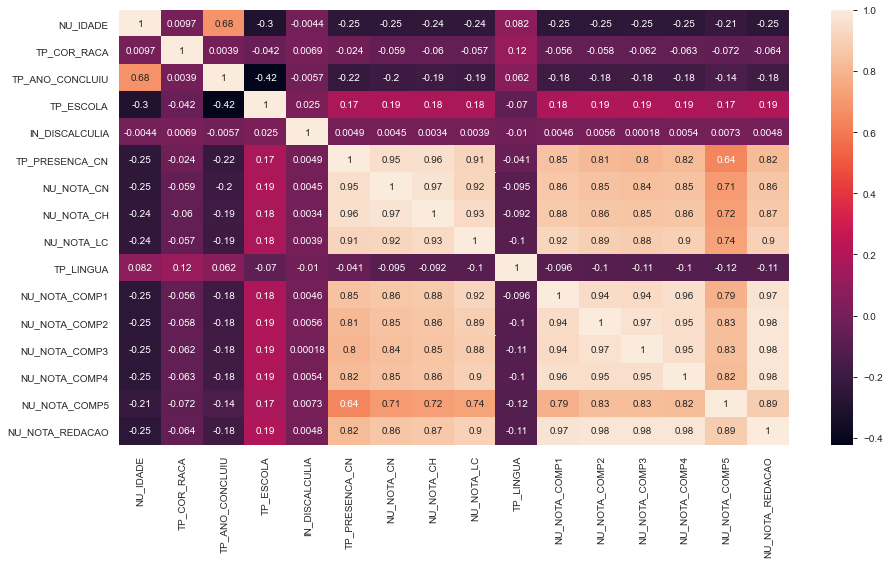

In [1131]:
# mapa de calor para visualizar a correlação entre as variáveis escolhidas 
correlacoes_features = df_train[features_columns].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(data=correlacoes_features, annot=True)

Com essas 28 features meu modelo usando o GradientBoostRegressor obteve o SCORE: 93,748981%.

Anteriormente, no desafio de entrada da aceleração, também usando o GradientBoostRegressor e com 22 features obtive o SCORE:93,78%.
    
Então, resolvi juntar a composição de features de ambos e rodar o modelo novamente.

Por fim, fiquei com as features abaixo:

In [1137]:
features =['NU_IDADE',
            'TP_SEXO',
            'TP_COR_RACA',
            'TP_ESCOLA',
            'IN_TREINEIRO',
            'TP_DEPENDENCIA_ADM_ESC',
            'IN_SABATISTA',
            'IN_GESTANTE',
            'IN_IDOSO',
            'TP_PRESENCA_CN',
            'TP_PRESENCA_CH',
            'TP_PRESENCA_LC',
            'CO_PROVA_CN',
            'CO_PROVA_CH',
            'CO_PROVA_LC',
            'CO_PROVA_MT',
            'NU_NOTA_CN',
            'NU_NOTA_CH',
            'NU_NOTA_LC',
            'NU_NOTA_COMP1',
            'NU_NOTA_COMP2',
            'NU_NOTA_COMP3',
            'NU_NOTA_COMP4',
            'NU_NOTA_COMP5',
            'NU_NOTA_REDACAO',
            'Q001',
            'Q002',
            'Q006',
            'Q024',
            'Q025',
            'Q026',
            'Q027',
            'Q047',
            'NU_NOTA_MT'] 

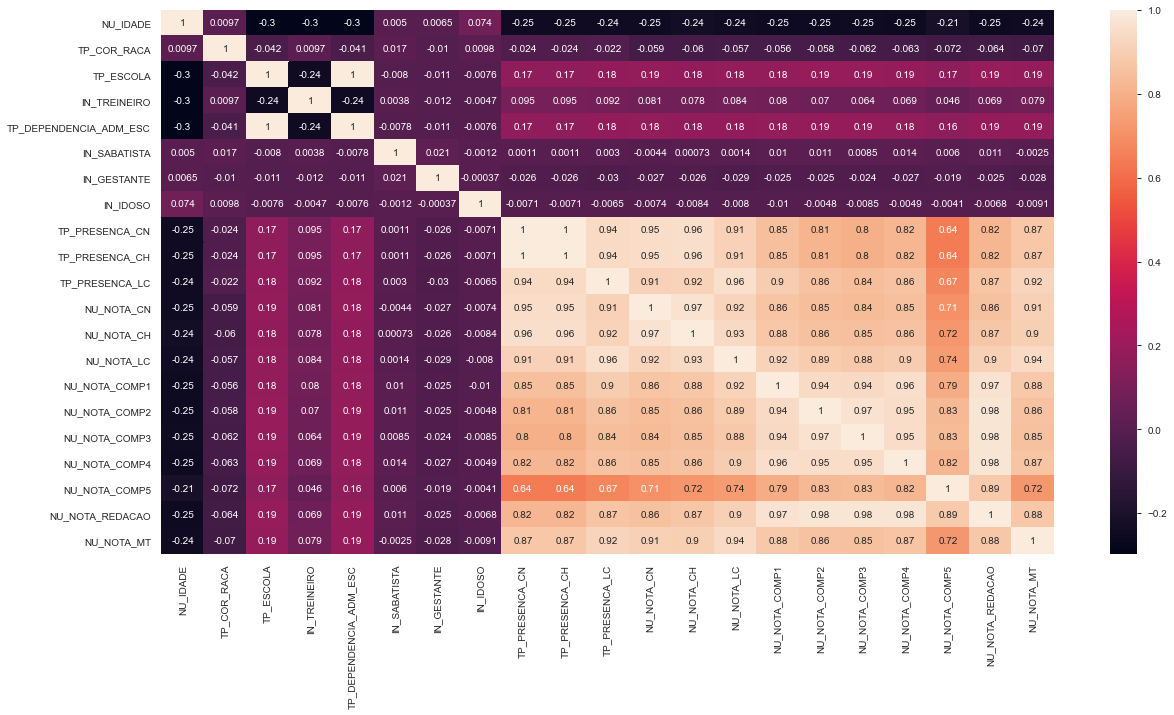

In [1130]:
# mapa de calor para visualizar a correlação entre as variáveis escolhidas 
correlacoes_features = df_train[features].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlacoes_features, annot=True)

In [1140]:
# remove a variável target de features
features.remove('NU_NOTA_MT')

In [1142]:
# verifica as vars categórias
categorical_var = df_train.select_dtypes(exclude='number').columns.tolist()
categorical_var

['NU_INSCRICAO',
 'SG_UF_RESIDENCIA',
 'TP_SEXO',
 'CO_PROVA_CN',
 'CO_PROVA_CH',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

In [1143]:
# converte essas colunas em string para posterior transformação
df_train['Q027']= df_train['Q027'].astype(str)
df_test['Q027']= df_test['Q027'].astype(str)

In [1144]:
# transforma as features TREINO não númericas em campos númericos
LE = LabelEncoder()
for coluna in df_train.columns:
        if coluna in categorical_var:
            try:
                df_train[coluna] = LE.fit_transform(df_train[[coluna]])

            except:
                print(f"Nao foi possivel realizar a operacao para a coluna {coluna}")

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1146]:
# transforma as features TESTE não númericas em campos númericos
LE = LabelEncoder()
for coluna in df_test.columns:
        if coluna in categorical_var:
            try:
                df_test[coluna] = LE.fit_transform(df_test[[coluna]])

            except:
                print(f"Nao foi possivel realizar a operacao para a coluna {coluna}")

### Modelo com GradientBoostRegressor
___

In [1155]:
# separando os dados de treino e test
X_train = df_train[features]
y_train = df_train['NU_NOTA_MT']  # variável target
X_test = df_test[features]

In [1156]:
# importa o modelo GradientBoostingRegressor e normaliza os dados com o StandardScaler
pipe_GBM = Pipeline([('scaler',StandardScaler()),('GradientBoostingRegressor',GradientBoostingRegressor())])
CV_pipe_GBM = RandomizedSearchCV(estimator = pipe_GBM, param_distributions = {},cv = 5,return_train_score=True, verbose=0)
CV_pipe_GBM.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('GradientBoostingRegressor',
                                              GradientBoostingRegressor(alpha=0.9,
                                                                        ccp_alpha=0.0,
                                                                        criterion='friedman_mse',
                                                                        init=None,
                                                                        learning_rate=0.1,
                                                                        loss='ls',
                        

In [1157]:
# faz a predição das notas de matemática
y_pred = CV_pipe_GBM.predict(X_test)

In [1158]:
# armazena as notas que o modelo preveu no dataset resposta
df_resposta['NU_NOTA_MT'] = np.around(y_pred,2)

In [1159]:
# gera o arquivo de respostas com a inscrição do aluno e a nota de matemática predita
df_resposta.to_csv('answer.csv', index=False, header=True)

In [1160]:
# verifica o dataset final
df_resposta

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,432.45
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,443.34
2,b38a03232f43b11c9d0788abaf060f7366053b6d,596.28
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,-1.54
4,715494628a50142ce8cb17191cfe6d0f3cae0934,563.97
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,457.97
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,471.08
4573,655fa6306720ff16e825903b5422a46608a77545,673.66
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,455.41


____

#### Considerações Finais

Fiz alguns testes incluindo e excluindo algumas features, deixei abaixo as descrições das features que usei e o respectivo score obtido.

Como podemos ver obtive o melhor score com as features acima que usei no modelo final, obtendo um score final 93.803521.


- #### Score obtido no desafio da semana: 93.792215%

features =['NU_IDADE',
            'TP_SEXO',
            'TP_COR_RACA',
            'TP_ST_CONCLUSAO',
            'TP_ANO_CONCLUIU',
            'TP_ESCOLA',
            'IN_DISCALCULIA',
            'CO_PROVA_CH',
            'CO_PROVA_LC',
            'CO_PROVA_MT',
            'TP_PRESENCA_CN',
            'TP_LINGUA',
            'NU_NOTA_COMP1',
            'NU_NOTA_COMP2',
            'NU_NOTA_COMP3',
            'NU_NOTA_COMP4',
            'NU_NOTA_COMP5',
            'NU_NOTA_CN',
            'NU_NOTA_CH',
            'NU_NOTA_LC',
            'NU_NOTA_REDACAO',
            'Q001',
            'Q002',
            'Q006',
            'Q024',
            'Q025',
            'Q026',
            'Q027',
            'Q047',
            'SG_UF_RESIDENCIA',
            'CO_UF_RESIDENCIA',
            'NU_NOTA_MT'] 

____
- #### Score obtido no desafio da semana: 93.795454%

features =['SG_UF_RESIDENCIA',
            'CO_UF_RESIDENCIA',
            'NU_IDADE',
            'TP_SEXO',
            'TP_COR_RACA',
            'TP_ST_CONCLUSAO',
            'TP_ANO_CONCLUIU',
            'TP_ESCOLA',
            'IN_TREINEIRO',
            'TP_DEPENDENCIA_ADM_ESC',
            'IN_SABATISTA',
            'IN_GESTANTE',
            'IN_IDOSO',
            'TP_PRESENCA_CN',
            'TP_PRESENCA_CH',
            'TP_PRESENCA_LC',
            'CO_PROVA_CN',
            'CO_PROVA_CH',
            'CO_PROVA_LC',
            'CO_PROVA_MT',
            'NU_NOTA_CN',
            'NU_NOTA_CH',
            'NU_NOTA_LC',
            'NU_NOTA_COMP1',
            'NU_NOTA_COMP2',
            'NU_NOTA_COMP3',
            'NU_NOTA_COMP4',
            'NU_NOTA_COMP5',
            'NU_NOTA_REDACAO',
            'Q001',
            'Q002',
            'Q006',
            'Q024',
            'Q025',
            'Q026',
            'Q027',
            'Q047',
            'NU_NOTA_MT'] 

____
- #### Score obtido no desafio da semana: 93.802485%

features =['NU_IDADE',
            'TP_SEXO',
            'TP_COR_RACA',
            'TP_ST_CONCLUSAO',
            'TP_ANO_CONCLUIU',
            'TP_ESCOLA',
            'IN_TREINEIRO',
            'TP_DEPENDENCIA_ADM_ESC',
            'IN_SABATISTA',
            'IN_GESTANTE',
            'IN_IDOSO',
            'TP_PRESENCA_CN',
            'TP_PRESENCA_CH',
            'TP_PRESENCA_LC',
            'CO_PROVA_CN',
            'CO_PROVA_CH',
            'CO_PROVA_LC',
            'CO_PROVA_MT',
            'NU_NOTA_CN',
            'NU_NOTA_CH',
            'NU_NOTA_LC',
            'NU_NOTA_COMP1',
            'NU_NOTA_COMP2',
            'NU_NOTA_COMP3',
            'NU_NOTA_COMP4',
            'NU_NOTA_COMP5',
            'NU_NOTA_REDACAO',
            'Q001',
            'Q002',
            'Q006',
            'Q024',
            'Q025',
            'Q026',
            'Q027',
            'Q047',
            'NU_NOTA_MT'] 

____
- #### Score obtido no desafio da semana: 93.802712%

features =['NU_IDADE',
            'TP_SEXO',
            'TP_COR_RACA',
            'TP_ANO_CONCLUIU',
            'TP_ESCOLA',
            'IN_TREINEIRO',
            'TP_DEPENDENCIA_ADM_ESC',
            'IN_SABATISTA',
            'IN_GESTANTE',
            'IN_IDOSO',
            'TP_PRESENCA_CN',
            'TP_PRESENCA_CH',
            'TP_PRESENCA_LC',
            'CO_PROVA_CN',
            'CO_PROVA_CH',
            'CO_PROVA_LC',
            'CO_PROVA_MT',
            'NU_NOTA_CN',
            'NU_NOTA_CH',
            'NU_NOTA_LC',
            'NU_NOTA_COMP1',
            'NU_NOTA_COMP2',
            'NU_NOTA_COMP3',
            'NU_NOTA_COMP4',
            'NU_NOTA_COMP5',
            'NU_NOTA_REDACAO',
            'Q001',
            'Q002',
            'Q006',
            'Q024',
            'Q025',
            'Q026',
            'Q027',
            'Q047',
            'NU_NOTA_MT'] 

____
- ### Score FINAL obtido no desafio da semana

features =['NU_IDADE',
            'TP_SEXO',
            'TP_COR_RACA',
            'TP_ESCOLA',
            'IN_TREINEIRO',
            'TP_DEPENDENCIA_ADM_ESC',
            'IN_SABATISTA',
            'IN_GESTANTE',
            'IN_IDOSO',
            'TP_PRESENCA_CN',
            'TP_PRESENCA_CH',
            'TP_PRESENCA_LC',
            'CO_PROVA_CN',
            'CO_PROVA_CH',
            'CO_PROVA_LC',
            'CO_PROVA_MT',
            'NU_NOTA_CN',
            'NU_NOTA_CH',
            'NU_NOTA_LC',
            'NU_NOTA_COMP1',
            'NU_NOTA_COMP2',
            'NU_NOTA_COMP3',
            'NU_NOTA_COMP4',
            'NU_NOTA_COMP5',
            'NU_NOTA_REDACAO',
            'Q001',
            'Q002',
            'Q006',
            'Q024',
            'Q025',
            'Q026',
            'Q027',
            'Q047',
            'NU_NOTA_MT'] 

![title](score_enem2.png)

____
## Conclusão
___

Aplicando as técnicas de features engineering aprendidas no curso para melhorar o desempenho do modelo

O RFE, ou eliminação recursiva de recursos, é um algoritmo de seleção de recursos. É muito popular porque é fácil de configurar e usar e porque é eficaz na seleção dos recursos (colunas) em um conjunto de dados de treinamento que são mais ou mais relevantes na previsão da variável de destino.

Pra esse desafio da semana também utilizei o modelo **GradientBoostRegressor** com 34 features com uma melhora no resultado obtendo **score de 93,803521%.** 

O objetivo do score do desafio da semana foi alcançado e os próximos passos é aprender sobre as outras técnicas de features engineering.

Entretanto, com o fim da aceleração a plataforma não estará mais acessível para submeter o modelo e validar o score.

____